# 1. Multi-Armed Bandit
> Imagine you are at a casino playing slots (hence the term "arm"). The slot machines are bandits because they are taking your money. Not all the slot machines are equal, and the win rate is generally unknown. For example, they may be:
* 1 pays out 30% of the time
* 1 pays out 20% of the time
* and 1 pays out 10% of the time

Keep in mind that you wouldn't know this, and would only be able to discover it by collecting data. Your goal is to *maximize your winnings*. If you were psychic and you could determine the machine with the highest win rate, you would play only that machine, and that is how you would maximize your winnings. But, since you don't know the win rates and your need to estimate them by collecting data, that means you need to play each of the machines. 

This is where the dilemma comes in: You need to collect enough data for your estimates to be accurate, but if you collect lots of data then you are going to spend lots of time playing suboptimal bandits. So, you need to balance between trying to maximize your earnings, and trying to obtain accurate measurements of each bandits win rate, since in order to maximize your earnings, you need to know that information. 

## Traditional A/B Testing
In traditional A/B testing, you would predetermine ahead of time the number of times you need to play each bandit in order to obtain statistical significance. The number of times you need to play is dependent upon a number of things, such as the difference in win rates between each bandit. If the difference is bigger you need less samples, but if the difference is smaller you need more samples. This is kind of odd, since you _don't know the difference before you start the test_. An important rule of traditional A/B testing is that you do not stop your test early. So if you decide before hand that you need to play each bandit 1000 times (N = 1000), and after 500 trials you have calculated a 90% win rate for one bandit, and a 10% win rate for the other, you are not allowed to stop. However, we are not going to care about statistical significance in these notebooks, so we don't need to follow those rules. 

## Human Behavior 
What is very interesting is that humans behave the opposite from this. Suppose you are playing in a real casino, and you get 2/3 on bandit A, and 0/3 on bandit B. You would have a strong urge to play bandit A, even though their true win rates are probably not 67% and 0%. As a data scientist, you know that there is a low probability that the first bandit has a win rate of 67%, and a low probability that the second bandit has a win rate of 0%. You know this because 3 is a very tiny sample size. Yet, if you are playing slot machines, you feel compelled to believe that the first bandit is better. 

Next, we will talk about algorithms that make an explicit trade off between exploration and exploitation. This will allow us to improve upon to the 2 suboptimal solutions we have just gone over: human behavior and traditional A/B testing. 

---

# 2. Epsilon-Greedy Solution 
One method of solving the explore-exploit dilemma is called the epsilon-greedy algorithm (and it is intuitive). This algorithm is used heavily in reinforcement learning. Here is how it works:
> Say you have some software that is serving 2 advertisements (A & B), you will *not* run a full A/B test by blindly serving ad A and ad B an equal # of times. Instead you will adapt to the data you have collected. If ad A is performing better, it will be shown more often. 

### How does it work?
It is simpler than it sounds! We start by choosing a small number epsilon ($\epsilon$) between 0 and 1, which will serve as our _probability of exploration_. Typical values are 10% or 5%. Some psuedo code may look like:

>```
epsilon = 0.1 
while True:
    r = rand()
    if r < epsilon:
        # explore
        # show random advertisement
    else:
        # exploit
        # show best advertisement (as determined by #clicks/#impressions)
```

Eventually, we'll discover the which arm is the true best, since this allows us to update every arm's estimate. 

### Analysis
In the long run, this technique allows us to explore each arm an infinite number of times. The problem with this is that eventually you will get to a point when you are still exploring, when in reality you don't need to explore any more. So, if epsilon is 10%, then you will spend 10% of the time chosing suboptimal arms. An A/B test could be useful here, where you perform the test at a predetermined time, and if you find statistical significan then set epsilon=0. However, there are better ways to adapt. 

---

# 3. Updating Sample Mean
Let's assume for a moment that our rewards are not just coin tosses, so we don't just need to store the number of success's and failures. The general method for solving this problem is to use the mean. This works for coin tosses too, since if you add up all of the 0's and 1's that you get, and divide by $N$, you arrive at the maximum likelihood probability.

So, how do we calculate the sample mean of a random variable? We know that it is the total sum, divided by the number of samples:

#### $$\bar{X} = \frac{1}{N}\sum_{i=1}^N X_i$$

What is the problem with this equation? The problem is that we need to keep track of **ALL** $N$ elements, in order to calculate the mean. And what if they can't fit into memory? Is there a way to make this calculation more efficient? There most definitely is. The trick is, the mean at the $N$th sample, can be calculated based on the mean at the $(N-1)$th sample. 

#### $$\bar{X}_N =  \frac{1}{N}\sum_{n=1}^NX_n = \frac{1}{N}\Big((N-1)\bar{X}_{N-1} + X_N \Big) = (1 - \frac{1}{N})\bar{X}_{N-1}+\frac{1}{N}X_N$$

We can then express this using simpler symbols. We can call $Y$ our output, and we can use $t$ to represent the current time step:

#### $$\bar{X}_N = (1 - \frac{1}{N})\bar{X}_{N-1} + \frac{1}{N}X_N$$

Note: This is also known as the **exponentially smoothed average**, and more can be seen in my notebook on Modern Deep Learning, specifically the section concerning momentum and the ADAM optimizer. 

---
# 4. Epsilon-Greedy in Code 

In [1]:
# Standard Library Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Seaborn Plot Styling
sns.set(style="white", palette="husl")
sns.set_context("poster")
sns.set_style("ticks")

Create a custom plotting function.

In [2]:
def plot_function(x, y_arr, title, legend, xlabel, ylabel, scale=False):
  """Set fig size, Plot Ground Truth Function, X axis"""
  fig, ax = plt.subplots(figsize=(10,6))
  for y in y_arr:
    plt.plot(x, y)

  """Create legend & labels"""
  if legend != False:
    ax.legend([l for l in legend], fontsize=20)
  plt.title(title)
  ax.set_xlabel(xlabel, fontsize=20)
  ax.set_ylabel(ylabel, fontsize=20)
  
  if scale == True:
    plt.xscale('log')

  return plt.show()

Epsilon =  0.1
1.0357590313204639
1.9864389191430012
3.0027025605482
-----------------------------
Epsilon =  0.05
1.0286637054302574
1.9928433799171335
2.993940850207759
-----------------------------
Epsilon =  0.1
0.9855617910506163
2.01406135861217
3.001476097003735
-----------------------------


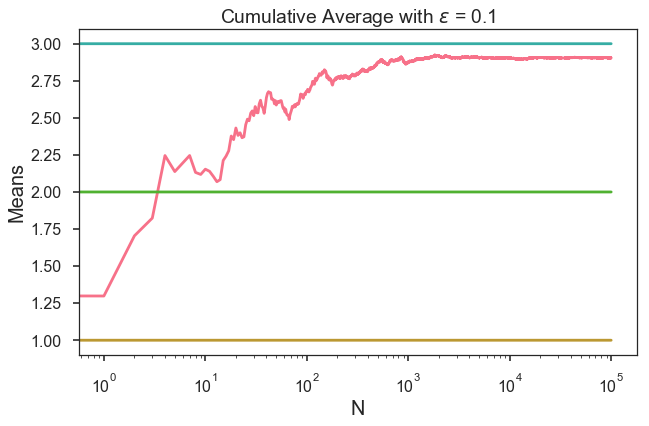

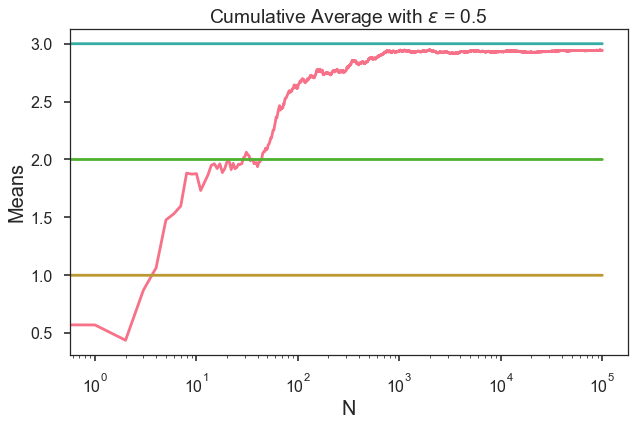

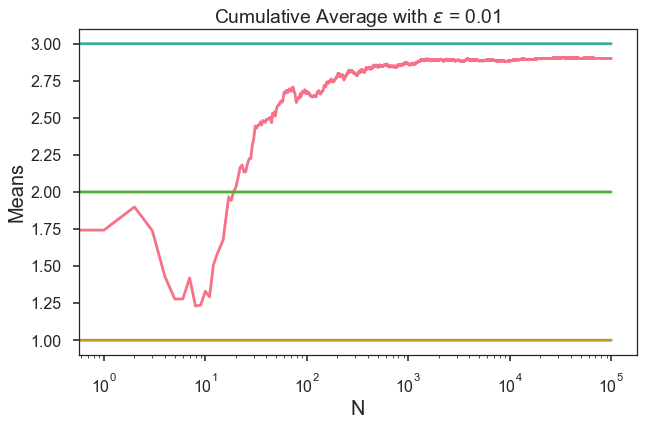

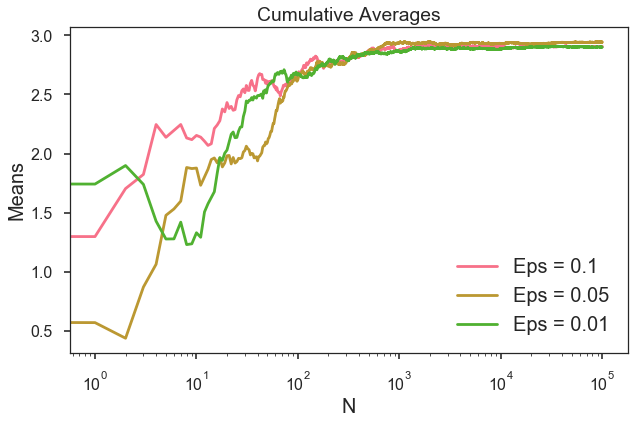

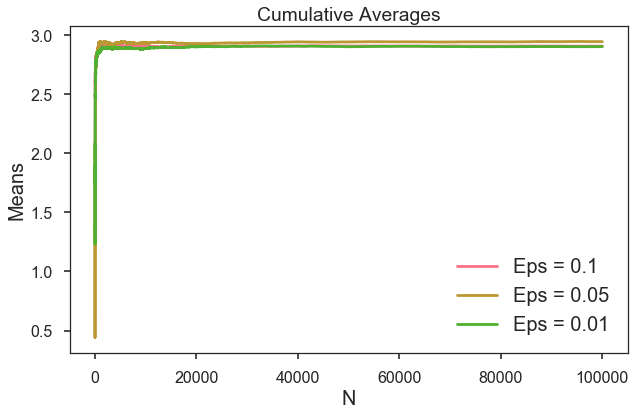

In [3]:
class Bandit: 
  def __init__(self, m):
    self.m = m       # True mean
    self.mean = 0    # Estimated mean that evolves as we explore 
    self.N = 0
    
  def pull(self):
    return np.random.randn() + self.m
  
  def update(self, X):
    self.N += 1
    self.mean = (1 - 1.0 / self.N) * self.mean + (1.0 / self.N) * X
    
def run_experiment_eps(m1, m2, m3, eps, N):
  bandits = [Bandit(m1), Bandit(m2), Bandit(m3)]
  
  data = np.empty(N)
  
  for i in range(N):
    
    # Epsilon Greedy
    p = np.random.random()
    if p < eps:
      j = np.random.choice(3)
    else:
      j = np.argmax([b.mean for b in bandits])
    
    x = bandits[j].pull() # Pull
    bandits[j].update(x) # Update
    
    # Get data for plot
    data[i] = x
  cumulative_average = np.cumsum(data) / (np.arange(N) + 1)
  
  print('Epsilon = ', eps)
  for b in bandits:
    print (b.mean)
  print('-----------------------------')
  return cumulative_average

if __name__ == '__main__':
  N = 100000
  m1 = 1.0
  m2 = 2.0
  m3 = 3.0
  
  c_1 = run_experiment_eps(m1, m2, m3, 0.1, N)
  c_05 = run_experiment_eps(m1, m2, m3, 0.05, 100000)
  c_01 = run_experiment_eps(m1, m2, m3, 0.1, 100000)
  
  # Plot moving average center
  x = np.arange(N)
  c1_y_arr = [c_1, np.ones(N) * m1, np.ones(N) * m2, np.ones(N) * m3]
  plot_function(x, c1_y_arr, 'Cumulative Average with $\epsilon$ = 0.1', False, 'N', 'Means', True)
  
  c05_y_arr = [c_05, np.ones(N) * m1, np.ones(N) * m2, np.ones(N) * m3]
  plot_function(x, c05_y_arr, 'Cumulative Average with $\epsilon$ = 0.5', False, 'N', 'Means', True)

  c01_y_arr = [c_01, np.ones(N) * m1, np.ones(N) * m2, np.ones(N) * m3]
  plot_function(x, c01_y_arr, 'Cumulative Average with $\epsilon$ = 0.01', False, 'N', 'Means', True)

  # Plot cumulative averages for all epsilon
  c_arr = [c_1, c_05, c_01]
  plot_function(x, c_arr, 'Cumulative Averages', ['Eps = 0.1', 'Eps = 0.05', 'Eps = 0.01'], 'N', 'Means', True)

  # Plot cumulative averages for all epsilon (Linear)
  plot_function(x, c_arr, 'Cumulative Averages', ['Eps = 0.1', 'Eps = 0.05', 'Eps = 0.01'], 'N', 'Means')

---

# 5. Optimistic Initial Values 
We will now look at another way of sovling the explore-exploit dilemma. Suppose you know that the true mean of the bandits was much less than 10. The idea is that you want to pick a high ceiling for the initial estimate of the bandit mean, and then do your update based on that. In other words, before we had:

#### $$\bar{X_0} = 0$$

And now we have:

#### $$\bar{X_0} = 10$$

We say that this is *optimistic* because the intial value for the sample mean is too good to be true. Since it is too good to be true, the only thing that can ever happen is that it will go down. So, if the mean is 1, as we collect more samples the mean will still converge to 1. In fact, eventually all of the means will eventually settle into their true values, at which point we will just be exploiting. Clearly, this will help exploration as well! If you haven't explored a bandit much, then its sample mean is going to remain very high, causing you to explore it more. In fact, it will remain higher than everything else, leaving you forced to explore it. So, in the main loop we need to still perform the greedy strategy, but using these optimistic means. 

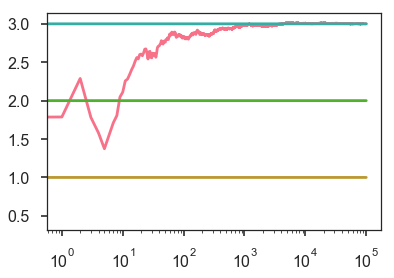

2.7947670007137155
2.8634856793879253
3.00081021075408


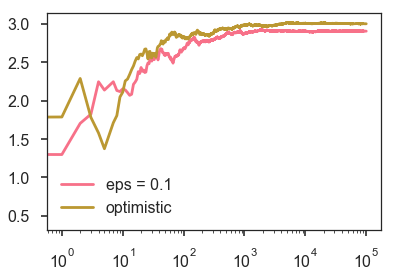

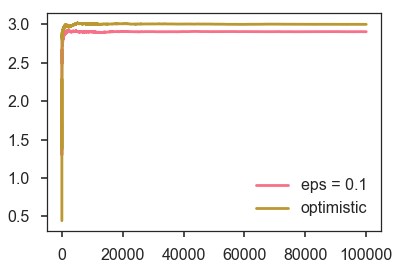

In [4]:
class Bandit: 
  def __init__(self, m, upper_limit):
    self.m = m
    self.mean = upper_limit # UPDATE 
    self.N = 1
    
  def pull(self):
    return np.random.randn() + self.m
  
  def update(self, X):
    self.N += 1
    self.mean = (1 - 1.0 / self.N) * self.mean + (1.0 / self.N) * X
    
def run_experiment(m1, m2, m3, N, upper_limit=10):
  bandits = [Bandit(m1, upper_limit), Bandit(m2, upper_limit), Bandit(m3, upper_limit)]
  
  data = np.empty(N)
  
  for i in range(N):
    
    # Greedy Portion (Epsilon removed) UPDATE
    j = np.argmax([b.mean for b in bandits])
    x = bandits[j].pull() # Pull
    bandits[j].update(x) # Update
                  
    # Get data for plot
    data[i] = x
  cumulative_average = np.cumsum(data) / (np.arange(N) + 1)
    
  # Plot moving average center
  plt.plot(cumulative_average)
  plt.plot(np.ones(N) * m1)
  plt.plot(np.ones(N) * m2)
  plt.plot(np.ones(N) * m3)
  plt.xscale('log')
  plt.show()
  
  for b in bandits:
    print (b.mean)
  return cumulative_average

if __name__ == '__main__':
  oiv = run_experiment(1.0, 2.0, 3.0, 100000)
  
  # log scale plot
  plt.plot(c_1, label='eps = 0.1')
  plt.plot(oiv, label='optimistic')
  plt.legend()
  plt.xscale('log')
  plt.show()


  # linear plot
  plt.plot(c_1, label='eps = 0.1')
  plt.plot(oiv, label='optimistic')
  plt.legend()
  plt.show()

---

# 6. UCB1
Another method to solve the explore/exploit dilemma is the UCB1 algorithm. Intuitively, we know that if you collect 10 samples and take the mean, this is not as accurate as if you collect 1000 samples and take the mean. If you were to draw a confidence bound around the 10 sample mean, it would be much wider than that which was around the 1000 sample mean. 

In statistics, there is a bound called the **Chernoff-Hoeffding** bound. This states that our confidence bound changes exponentially with the number of samples we collect:

### $$P \{|\bar{X} - \mu| \geq \epsilon\} \leq 2e^{\{-2\epsilon^2N\}}$$ 

It looks complicated, but becomes less complicated when dissected slowly! It says that:

> "_The probability that the absolute difference between the sample mean and the true mean is greater than or equal to $\epsilon$, is less than 2 times the exponent of -2 times $\epsilon^2$ times N._ Here, $N$ is the number of samples collected and $\epsilon$ is just a very small number."

The full background is outside the scope of what we are looking at in terms of RL, however, the main idea is similar to the other algorithms we have looked at so far. The idea is that we take the upper confidence bound (**UCB**) to be the regular sample mean, plus the square root of $2ln(N)$ divided by $N_j$ (the number of times bandit $j$ has been played:

#### $$X_{UCB-j} = \bar{X}_j + \sqrt{2\frac{lnN}{N_j}}$$

In other words, we are stating that $\epsilon$ is defined as:

#### $$\epsilon = \sqrt{2\frac{lnN}{N_j}}$$

This is equivalent to choosing an epsilon equal to the square root and everything inside. So let's talk about what these symbols mean:

> * $\bar{X}_j$: Regular sample mean of the $j$th bandit
* **N**: Total number of times each bandit has been played
* $N_j$: The number of times the jth bandit has been played

Now, how do we use this formula? Well, the idea is similar to the optimistic initial values method. We use the greedy strategy only, but what we are greedy with respect to is not just the sample mean, but the upper confidence bound of the sample mean. Why does this work? Well, our confidence bound is the ratio of two things: $N$, the total number of times you have played, and $N_j$ which is the total number of times your have played bandit $j$. So, if you have played other bandits many times but you haven't played bandit $j$ very frequently ($N_j$ is small), then this ratio is going to be large. This would make the upper confidence bound higher, which would cause you to select this bandit to play. At the same time, if $N_j$ is large, then the ratio is small, at which point the upper confidence bound will shrink. 

One key thing about this ratio is that the top portion grows with the logarithm of $N$, hence it will grow more slowly than $N_j$ eventually. That means, as you play all of the bandits more and more, the upper confidence bounds will shrink, and you will only be using the sample means. This is okay, since we have collected lots of data at this point! At this point, we have also converged to a purely greedy strategy, based on only the sample means. 

Let's look at some pseudocode so we can understand how this works better. It is really just as simple as the optimistic initial values method, we are just replacing the formula which goes in the argmax, which is now the upper confidence bound. 

```
for n=1..N:
    j = argmax[j']{ bandit[j'].mean + sqrt(2*ln(n) / n_j') }
    pull bandit j
    update bandit j 
```

There is a small problem here, and that is what happens if $N_j = 0$? To fix that, we can just add a very small number to the denominator.  

In [145]:
class Bandit:
  def __init__(self, m):
    self.m = m    # True mean
    self.mean = 0 # Sample mean
    self.N = 0    # Number of pulls/trials for bandit instance
    
  def pull(self):
    return self.m + np.random.randn() # True mean + noise form a random normal distribution
  
  def update(self, X):
    self.N += 1 
    self.mean = (1 - 1.0 / self.N) * self.mean + (1.0 / self.N) * X

def ucb(mean, n, nj):
  return float('inf') if nj == 0 else mean + np.sqrt(2 * np.log(n) / nj)
  
def run_experiment_ucb1(m1, m2, m3, N, dbz=0.0001):
  bandits = [Bandit(m1), Bandit(m2), Bandit(m3)]
  data = np.empty(N)
  
  for n in range(1, N):
    j = np.argmax([ucb(b.mean, n, b.N) for b in bandits])
    x = bandits[j].pull()
    data[n] = x 
    bandits[j].update(x)

  
  for b in bandits:
    print('Bandit with true mean: ', b.m)
    print('Estimated Mean: ', b.mean)
    print('Final Number of Trials: ', b.N)
    print('------ \n')
    
  cumulative_average = np.cumsum(data) / (np.arange(N) + 1)

  plot_function(np.arange(0,N), [cumulative_average], 'UCB1 Algorithm', 'Legend', 
                'Iterations (N)', 'Cumulative Average', scale=True)
  return cumulative_average
  

Epsilon =  0.1
0.9907623764880082
1.9997875932379772
2.9965791291000174
-----------------------------
Bandit with true mean:  1.0
Estimated Mean:  1.105732812038793
Final Number of Trials:  7
------ 

Bandit with true mean:  2.0
Estimated Mean:  1.8893611743532164
Final Number of Trials:  19
------ 

Bandit with true mean:  3.0
Estimated Mean:  3.0003812725883794
Final Number of Trials:  99973
------ 



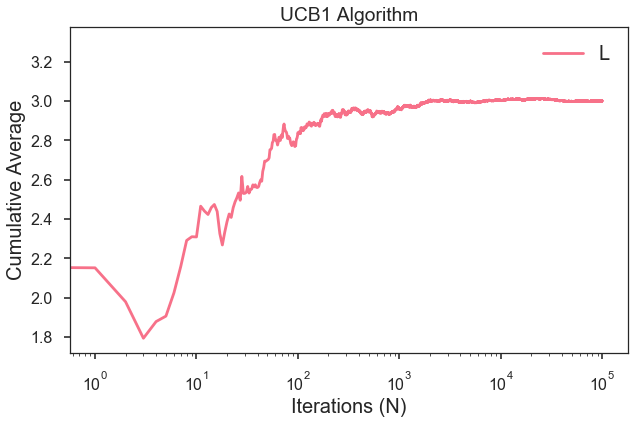

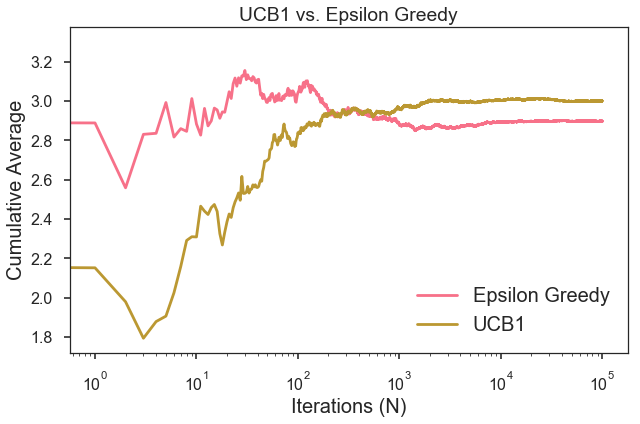

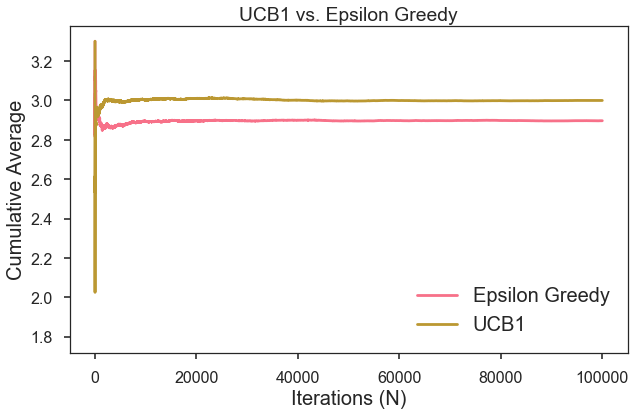

In [146]:
if __name__ == '__main__':
  eps = run_experiment_eps(1.0, 2.0, 3.0, 0.1, 100000)
  ucb = run_experiment_ucb1(1.0, 2.0, 3.0, 100000)

  # log scale plot
#   plt.plot(eps, label='eps = 0.1')
#   plt.plot(ucb, label='ucb1')

  plot_function(np.arange(0,100000), [eps, ucb], 'UCB1 vs. Epsilon Greedy', 
                ['Epsilon Greedy', 'UCB1'],'Iterations (N)', 
                'Cumulative Average', scale=True)

  plot_function(np.arange(0,100000), [eps, ucb], 'UCB1 vs. Epsilon Greedy', 
                ['Epsilon Greedy', 'UCB1'],'Iterations (N)', 
                'Cumulative Average', scale=False)